In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

In [103]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

In [104]:
inv = np.linalg.inv

# Generate sample time series data

Same as Linear Least Squares example, without the exponential.

In [201]:
t = np.linspace(0, 3, 60)
x = np.array([[1, 1, 2]]).T
H = np.vstack([t, np.sin(t), np.cos(2*t)]).T
y = H@x

# Two sensors

In [211]:
noise_mean = 0

noise_std_1 = 2
noise_std_2 = 0.5

v = []
v_std = []
noise_i = 1
n_chunks = 0
while len(v)<len(t):
    if noise_i == 1:
        noise_i = 2
        noise_std = noise_std_2
        chunk_size = 10
    else:
        noise_i = 1
        noise_std = noise_std_1
        chunk_size = 10
        
    v_std = np.hstack( (v_std, [noise_std]*chunk_size) ) 
    v = np.hstack( (v, np.random.normal(noise_mean, noise_std, chunk_size)) )
    n_chunks += 1

v_std = v_std[0:len(t)]
v = v[0:len(t)]

v_std = np.column_stack(v_std).T
v = np.column_stack(v).T

y_tilde = y+v

In [212]:
n_chunks

6

# Plotting

<Axes: xlabel='Time', ylabel='y'>

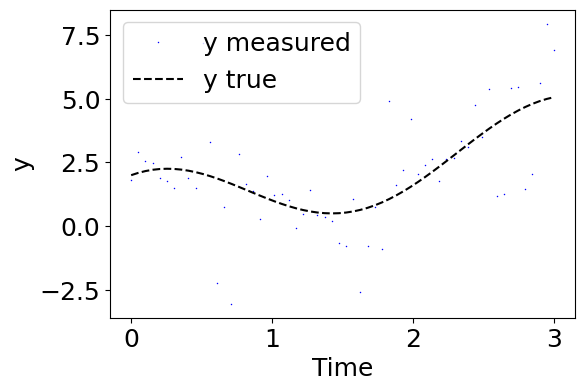

In [213]:
plot_tme(t, y, y_tilde)

# Candidate models

In [214]:
model_1_H = np.vstack([t, np.sin(t), np.cos(2*t)]).T

# Minimum Variance Estimate: Gauss-Markov Theorem

$\mathbf{\hat{x}}=(H^{\top}R^{-1}H)^{-1}H^{\top}R^{-1}\mathbf{\tilde{y}}$

In [215]:
R = np.diag( np.ravel(v_std)**2)
print(R)

[[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 4.   0.   0.  ]
 [0.   0.   0.   ... 0.   4.   0.  ]
 [0.   0.   0.   ... 0.   0.   4.  ]]


### Model 1

In [216]:
x_1_hat = inv(model_1_H.T@inv(R)@model_1_H)@model_1_H.T@inv(R)@y_tilde

<Axes: xlabel='Time', ylabel='y'>

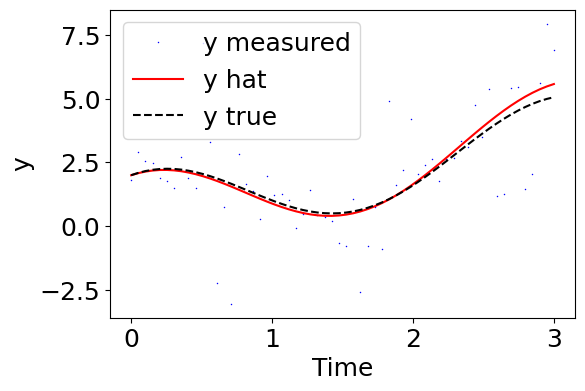

In [217]:
y_1_hat = model_1_H@x_1_hat
plot_tme(t, y, y_tilde, y_1_hat)

In [218]:
x_error = x_1_hat - x
print(x_error)

[[ 0.19108742]
 [-0.37516071]
 [-0.00185933]]


# Covariance of x error

In [219]:
P = x_error@x_error.T
print(P)

[[ 3.65144007e-02 -7.16884906e-02 -3.55295257e-04]
 [-7.16884906e-02  1.40745558e-01  6.97548919e-04]
 [-3.55295257e-04  6.97548919e-04  3.45712150e-06]]


# Cramer Rao Bound

In [220]:
CRB = inv(model_1_H.T@inv(R)@model_1_H)
print(CRB)

[[ 0.0187074  -0.0382313  -0.00475858]
 [-0.0382313   0.09765801  0.01904516]
 [-0.00475858  0.01904516  0.0216108 ]]


Text(0, 0.5, 'error variance')

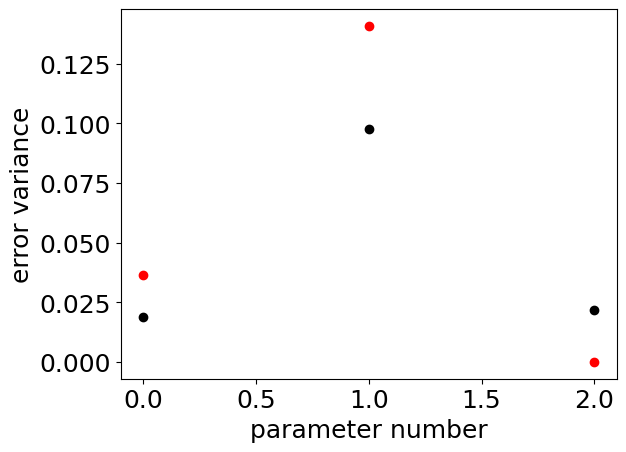

In [221]:
plt.plot(np.diag(P), 'o', color='red')
plt.plot(np.diag(CRB), 'o', color='black')

plt.xlabel('parameter number')
plt.ylabel('error variance')

# Exercises

1. Theory says that the diagonal elements of P (red points) should be equal to (or bigger than) the diagonal elements of CRB (black points) (provided enough data or replicates). Are they?
2. Rerun the code from the first cell (the data generation step). How do the diagonal elements compare now?
3. Put all the steps from data generation to calculating P and CRB into a single function (skip plotting). Run the function many (1000) times. How do the diagonal elements compare now?